<a href="https://colab.research.google.com/github/pankajrana1111/Image-Classification/blob/pankajrana1111-patch-1/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#getting repository from github
!git clone https://github.com/pankajrana1111/Image-Classification.git

fatal: destination path 'Image-Classification' already exists and is not an empty directory.


In [ ]:
#extacting data from the archived files
!pip install patool
import patoolib
patoolib.extract_archive("Image-Classification/fashion1.rar", outdir="Image-Classification")
patoolib.extract_archive("Image-Classification/fashion2.rar", outdir="Image-Classification")
patoolib.extract_archive("Image-Classification/fashion3.rar", outdir="Image-Classification")
patoolib.extract_archive("Image-Classification/fashion4.rar", outdir="Image-Classification")
patoolib.extract_archive("Image-Classification/fashion5.rar", outdir="Image-Classification")
patoolib.extract_archive("Image-Classification/fashion6.rar", outdir="Image-Classification")

In [5]:
# importing all required libararies. The libaries are imported in the sequence of their usage.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications import VGG16
from keras.applications import imagenet_utils

In [6]:
data=pd.read_csv("Image-Classification/train.csv")
data.head()

,files,target,images
0,../input/fashiondata/data/shoes/5da81ceb7861c2...,shoes,5da81ceb7861c2af6a5a89a7_1.jpg
1,../input/fashiondata/data/beauty/5da81d8a7861c...,beauty,5da81d8a7861c2af6a5a901c_3.jpg
2,../input/fashiondata/data/beauty/5da820f26504f...,beauty,5da820f26504fb65da0043e6_0.jpg
3,../input/fashiondata/data/jewelry and watches/...,jewelry and watches,5da81c026504fb65cea700d2_0.jpg
4,../input/fashiondata/data/bags/5da81d2c7861c2a...,bags,5da81d2c7861c2af6a5a8c64_2.jpg


COMMENT: From the first look of the dataframe we observed that the target variable contains the categories of the images.

In [7]:
##creating the lists of image locations
image_loc1=[os.path.join("Image-Classification/fashion1",img) for img in os.listdir("Image-Classification/fashion1")]
image_loc2=[os.path.join("Image-Classification/fashion2",img) for img in os.listdir("Image-Classification/fashion2")]
image_loc3=[os.path.join("Image-Classification/fashion3",img) for img in os.listdir("Image-Classification/fashion3")]
image_loc4=[os.path.join("Image-Classification/fashion4",img) for img in os.listdir("Image-Classification/fashion4")]
image_loc5=[os.path.join("Image-Classification/fashion5",img) for img in os.listdir("Image-Classification/fashion5")]
image_loc6=[os.path.join("Image-Classification/fashion6",img) for img in os.listdir("Image-Classification/fashion6")]

In [8]:
##combining all the images in one list
image_loc_list=image_loc1 + image_loc2 + image_loc3 + image_loc4 + image_loc5 + image_loc6
len(image_loc_list)

6000

In [23]:
image_loc_list[0:10]

['Image-Classification/fashion1/5da81b0a7f3e301b4504b3be_0.jpg',
 'Image-Classification/fashion1/5da81b2d6504fb65cb2616ce_3.jpg',
 'Image-Classification/fashion1/5da81a487d3a9baa211f7eeb_4.jpg',
 'Image-Classification/fashion1/5da81b33b25b035d1d17a5f6_2.jpg',
 'Image-Classification/fashion1/5da81aea7d3a9baa211f81cb_0.jpg',
 'Image-Classification/fashion1/5da81acb7d3a9baa211f7f80_2.jpg',
 'Image-Classification/fashion1/5da81a746504fb65cb26166d_2.jpg',
 'Image-Classification/fashion1/5da81b0a7f3e301b4504b3a0_0.jpg',
 'Image-Classification/fashion1/5da81b44b25b035d1d17a681_4.jpg',
 'Image-Classification/fashion1/5da81a447d3a9baa211f7e59_1.jpg']

#***Exploratory Data Analysis***

In [9]:
#checking size of the data
data.shape

(6000, 3)

In [10]:
#checking for any missing values in the data
data.isnull().sum()

files     0
target    0
images    0
dtype: int64

['shoes' 'beauty' 'jewelry and watches' 'bags']
[1465, 1524, 1503, 1508]


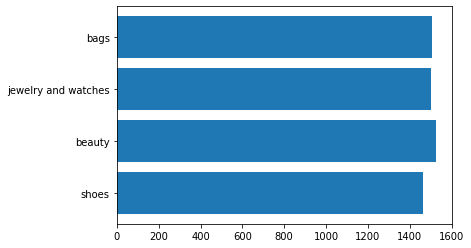

In [12]:
##plotting the no. of images in each category
y_labels=data.target.unique()
print (y_labels)
counts=[data.target.tolist().count(i) for i in y_labels]
print(counts)
plt.barh(y_labels,counts)
plt.show()

COMMENT: In the plot we observed that the no. of images in each category are almost equal and hence we have a balanced dataset.

In [13]:
# plotting sample images
def show_imgs(X):
    plt.figure(figsize=(8, 8))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            image = load_img(image_loc_list[k], target_size=(224, 224))
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(image)
            k = k+1
    plt.show()

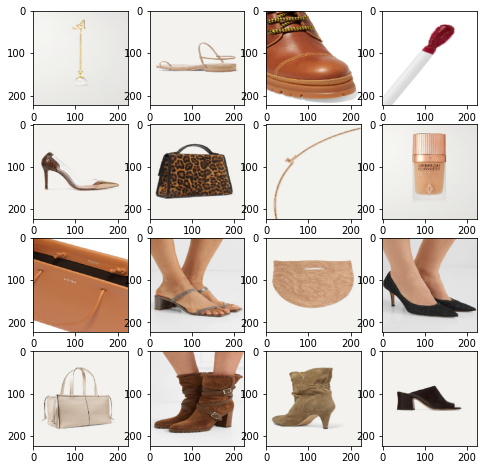

In [18]:
show_imgs(image_loc_list)

#***Feature Extraction***

In [15]:
# load the VGG16 network
print("[INFO] loading network...")
 
# chop the top dense layers, include_top=False
model = VGG16(weights="imagenet", include_top=False)
model.summary()

[INFO] loading network...
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None,

In [16]:
# Extracting/Creating features of each image in our dataset
def create_features(dataset, pre_model):
 
    x_scratch = []
 
    # loop over the images
    for imagePath in image_loc_list:
 
        # load the input image and image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
 
        # add the image to the batch
        x_scratch.append(image)
 
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    return x, features, features_flatten

In [ ]:
image_stack, features, features_flatten = create_features(image_loc_list, model)

In [ ]:
##Creating Dataframe out of extracted features
Pd_mat=pd.DataFrame(feature_flatten)

In [ ]:
##reading,processing and saving the image data into image_array list
j=0
image_array=[None]*len(image_loc_list)
for i in image_loc_list:
    image=cv2.imread(i)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image=cv2.resize(image,(100,100),cv2.INTER_LINEAR)
    image=image.reshape(100*100)
    image_array[j]=image
    j+=1    

In [ ]:
##removing any duplicates in the Predictor Matrix
Pd_mat.drop_duplicates()

In [ ]:
##displaying sample image
image_array=np.asarray(image_array)
plt.imshow(image_array[100].reshape(100,100),cmap="gray")